In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

sns.set_style('whitegrid')

In [5]:
column_names = [
    'id',
    'label',
    'statement',
    'subject',
    'speaker',
    'job_title',
    'state_info',
    'party_affiliation',
    'barely_true_counts',
    'false_counts',
    'half_true_counts',
    'mostly_true_counts',
    'pants_on_fire_counts',
    'context'
]

# Read the TSV files into pandas DataFrames
# use sep = \t because it is a TSV not csv
train_df = pd.read_csv("train.tsv", sep='\t', names=column_names)
test_df = pd.read_csv("test.tsv", sep='\t', names=column_names)
valid_df = pd.read_csv("valid.tsv", sep='\t', names=column_names)

print(f"Shape of the training set: {train_df.shape}")
print(f"Shape of the test set: {test_df.shape}")
print(f"Shape of the validation set: {valid_df.shape}")

Shape of the training set: (10240, 14)
Shape of the test set: (1267, 14)
Shape of the validation set: (1284, 14)


In [6]:
# combine all 3 dataframes ONLY for EDA (to get a better overall idea of data)
# add a source column to keep track of what dataframe is row is from
train_df['source_set'] = 'train'
test_df['source_set'] = 'test'
valid_df['source_set'] = 'valid'

# Concatenate the three dataframes into one
liar_df = pd.concat([train_df, test_df, valid_df], ignore_index=True)

# Display the shape and first few rows of the combined dataframe
print(f"\nShape of the combined dataset: {liar_df.shape}")
print("\nFirst 5 rows of the combined dataset:")
liar_df.head()


Shape of the combined dataset: (12791, 15)

First 5 rows of the combined dataset:


,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,source_set
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,train
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,train
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,train
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,train
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,train


In [12]:
# check data types, nulls
print("Data Types and Null Value Check (.info())")
liar_df.info()

print("\n" + "="*50 + "\n")

# basic stats of columns 8-12
print("Summary Statistics for Numerical Columns (.describe())")
liar_df.describe()

Data Types and Null Value Check (.info())
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12791 entries, 0 to 12790
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    12791 non-null  object 
 1   label                 12791 non-null  object 
 2   statement             12791 non-null  object 
 3   subject               12789 non-null  object 
 4   speaker               12789 non-null  object 
 5   job_title             9223 non-null   object 
 6   state_info            10040 non-null  object 
 7   party_affiliation     12789 non-null  object 
 8   barely_true_counts    12789 non-null  float64
 9   false_counts          12789 non-null  float64
 10  half_true_counts      12789 non-null  float64
 11  mostly_true_counts    12789 non-null  float64
 12  pants_on_fire_counts  12789 non-null  float64
 13  context               12660 non-null  object 
 14  source_set            12791 

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,word_count
count,12789.000000,12789.000000,12789.000000,12789.000000,12789.000000,12791.000000
mean,11.583939,13.359059,17.185785,16.497850,6.251388,18.040575
std,18.978037,24.140086,35.847678,36.165276,16.180777,10.129158
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000,17.000000
75%,12.000000,15.000000,13.000000,12.000000,5.000000,22.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000,467.000000


**Data types and Null takeaways**


*   12791 entries
*   columns (0-7, 13-14) are object types, and (8-12) are numerical. This lines up with the titles, where all 'counts' columns are numerical

*   The job_title column is missing about 3500 entries, with state_info missing about 2,700 entries.

*   Context column is missing 130, we can just remove these rows or figure out what to do in future.

*   A few other columns have a couple missing datapoints, but nothing serious.


**Summary Statistics Takeaway**

*   Right-Skewed Distributions: For all five credit history columns, the mean is much larger than the median. This indicates a strong right-skewed distribution, meaning that most of the speakers have very few prior statements, and a couple "common" speakers that pull up the average.

*   Outliers: We can see a large difference between the 75th percentile and our max for all of our variables. We will likely transform the data (using log or a robust scaler) to reduce the influence of these outliers.

*   Many New Speakers: The 25th percentile (25%) for every category is 0. This means that at least 25% of the entries are from speakers who have no recorded history in any of the truthfulness categories in this dataset.



The following cell will contain histograms of all of the numerical variables for an easy visualization of the data.






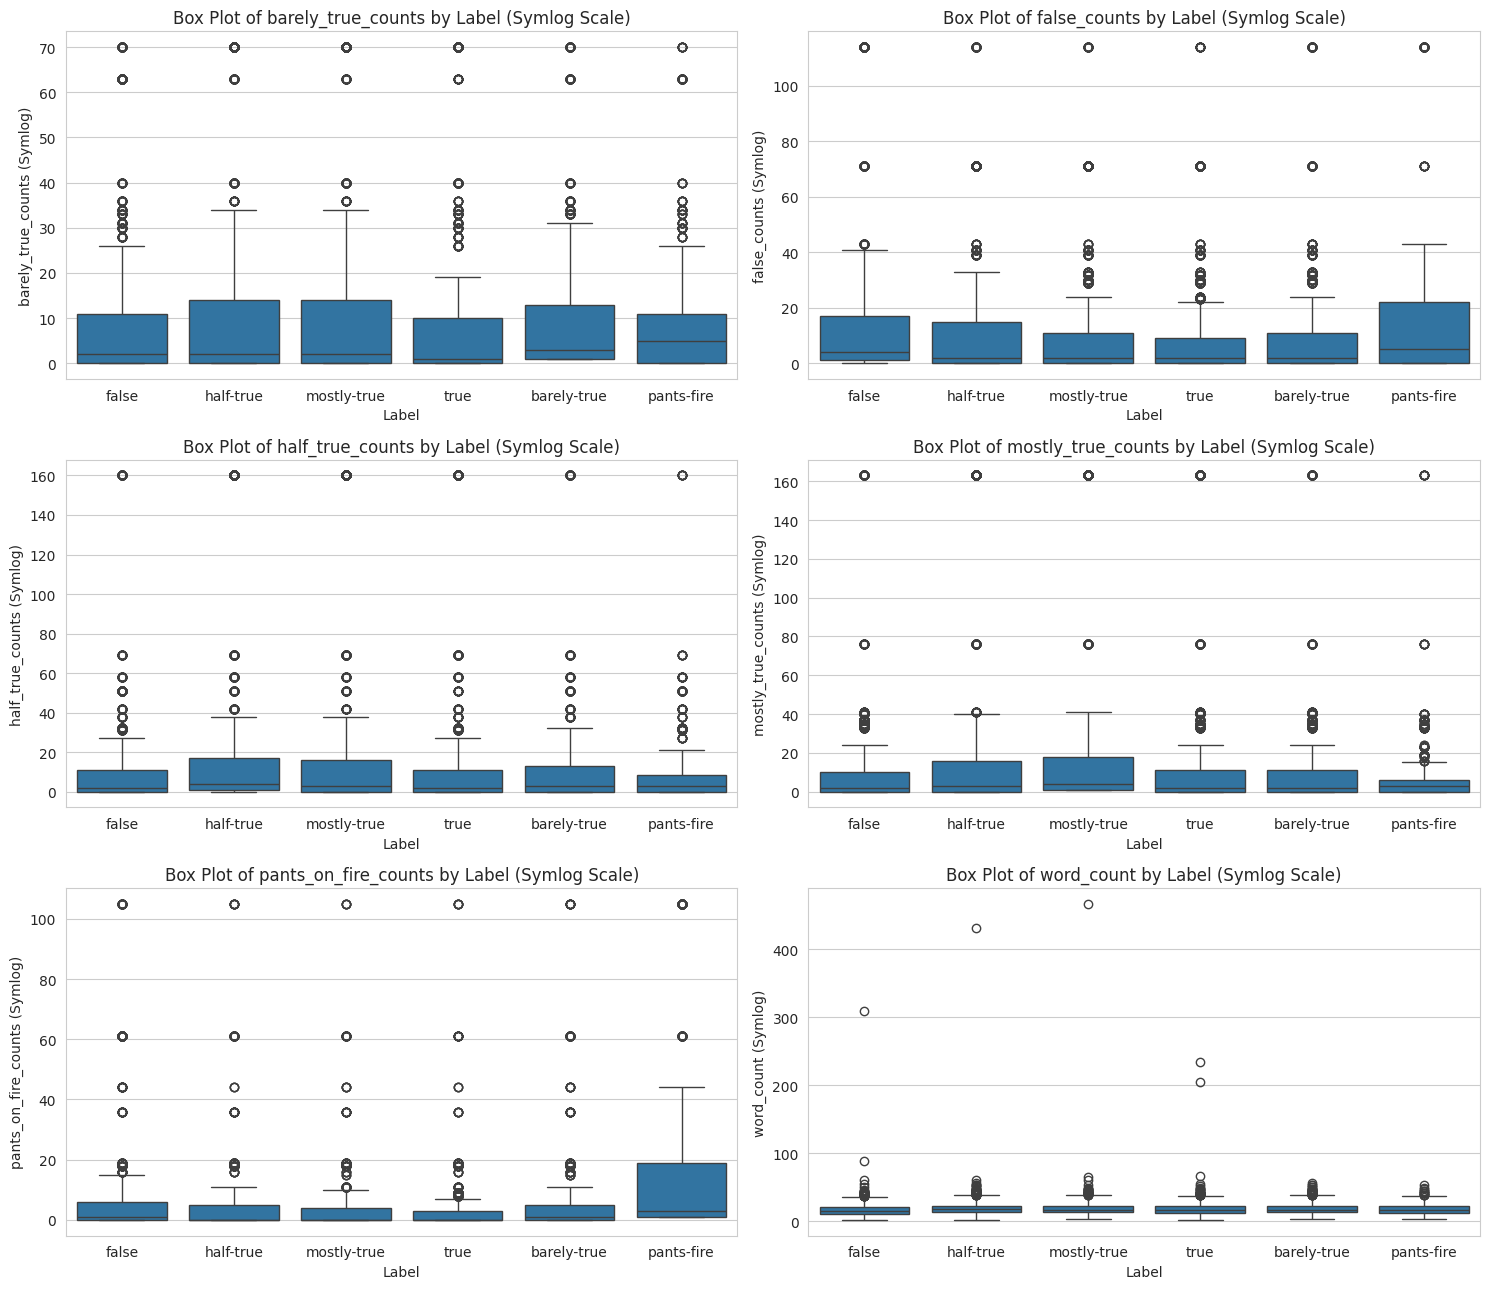

In [15]:
numerical_cols = [
    'barely_true_counts', 'false_counts', 'half_true_counts',
    'mostly_true_counts', 'pants_on_fire_counts', 'word_count'
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 13))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    ax = axes[i]

    sns.boxplot(
        x='label',
        y=col,
        data=liar_df,
        ax=ax
    )

    #ax.set_yscale('symlog')   #use this for a log scale

    ax.set_title(f'Box Plot of {col} by Label (Symlog Scale)')
    ax.set_xlabel('Label')
    ax.set_ylabel(f'{col} (Symlog)')

plt.tight_layout()
plt.show()

# Label (target)
Now that we have analyzed the basics of the numerical variables, lets move onto the categorical variables. The first variable we will look at will be our main target variable 'label'. This labels whether or not the story is truthful or not.

--- Counts of Each Label ---
label
half-true      2627
false          2507
mostly-true    2454
barely-true    2103
true           2053
pants-fire     1047
Name: count, dtype: int64


/tmp/ipython-input-158303257.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=liar_df, order=label_order, palette='viridis')


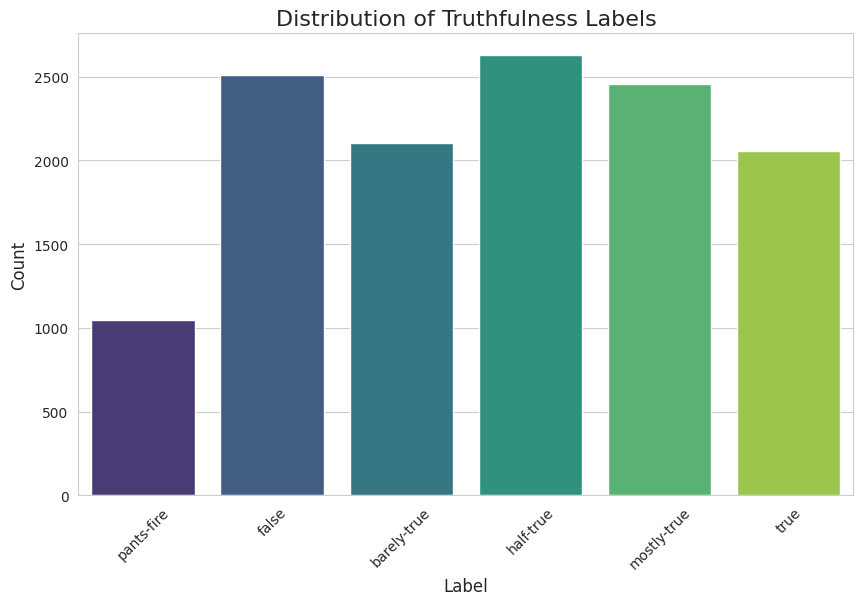

In [8]:
# Analyze target variable
label_counts = liar_df['label'].value_counts()

print("--- Counts of Each Label ---")
print(label_counts)

# bar graph of total target variable counts
plt.figure(figsize=(10, 6))

label_order = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
sns.countplot(x='label', data=liar_df, order=label_order, palette='viridis')

# add titles and labels
plt.title('Distribution of Truthfulness Labels', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45) # Rotate x-axis labels to prevent overlap

plt.show()

We check the totals of the target variables to make sure there is not a huge class imbalance, which can lead to biases or inaccuracies in our models.

In this dataset, all of the labels are fairly equal other than the pants-fire label, which is about half the count of the others. To account for this, we can use a technique like oversampling that label (creating additional copies) during the model training phase, or adding additional data from other databases that would match our pants-fire label.

**Party affiliation, speakers, subjects**

--- Top 10 Party Affiliations ---
party_affiliation
republican      5665
democrat        4137
none            2181
organization     264
independent      180
newsmaker         64
libertarian       51
journalist        49
activist          45
columnist         44
Name: count, dtype: int64


/tmp/ipython-input-188583639.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette=custom_palette)


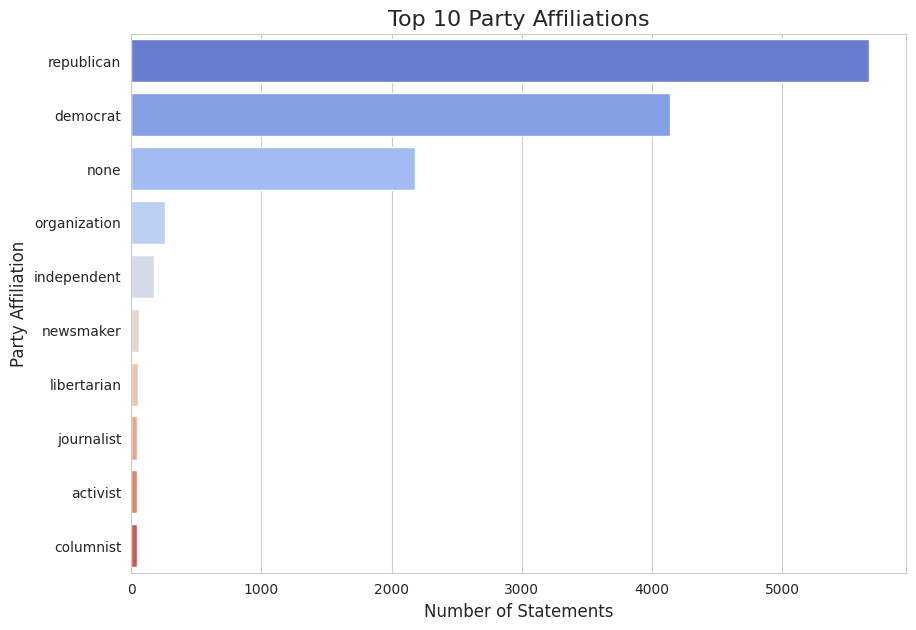


--- Top 10 Speakers ---
speaker
barack-obama       611
donald-trump       343
hillary-clinton    297
mitt-romney        212
john-mccain        189
scott-walker       183
chain-email        178
rick-perry         173
marco-rubio        153
rick-scott         150
Name: count, dtype: int64


/tmp/ipython-input-188583639.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette=custom_palette)


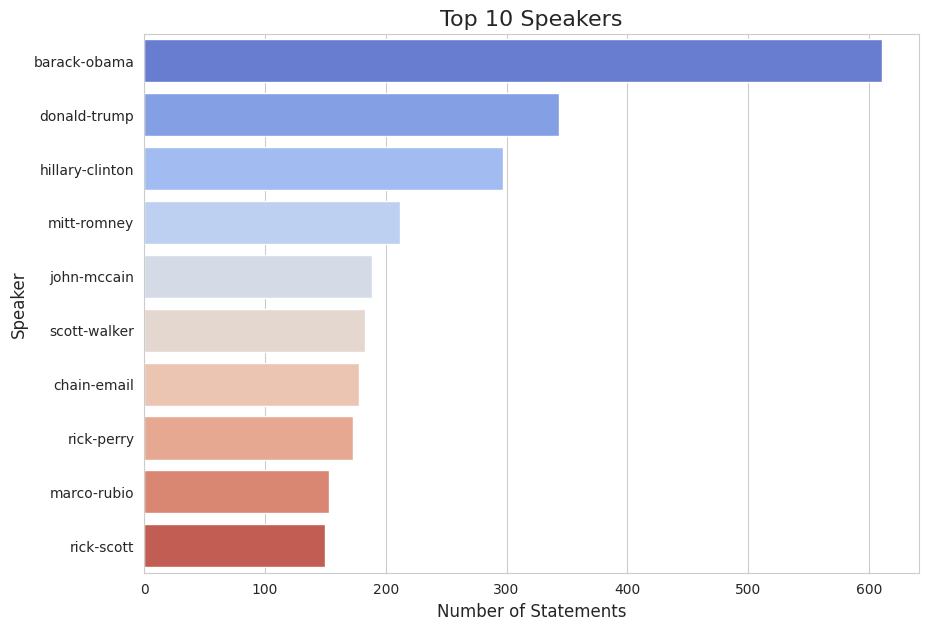


--- Top 10 Subjects ---
subject
health-care             474
taxes                   356
education               309
elections               304
immigration             303
candidates-biography    239
economy                 170
guns                    152
economy,jobs            152
federal-budget          152
Name: count, dtype: int64


/tmp/ipython-input-188583639.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette=custom_palette)


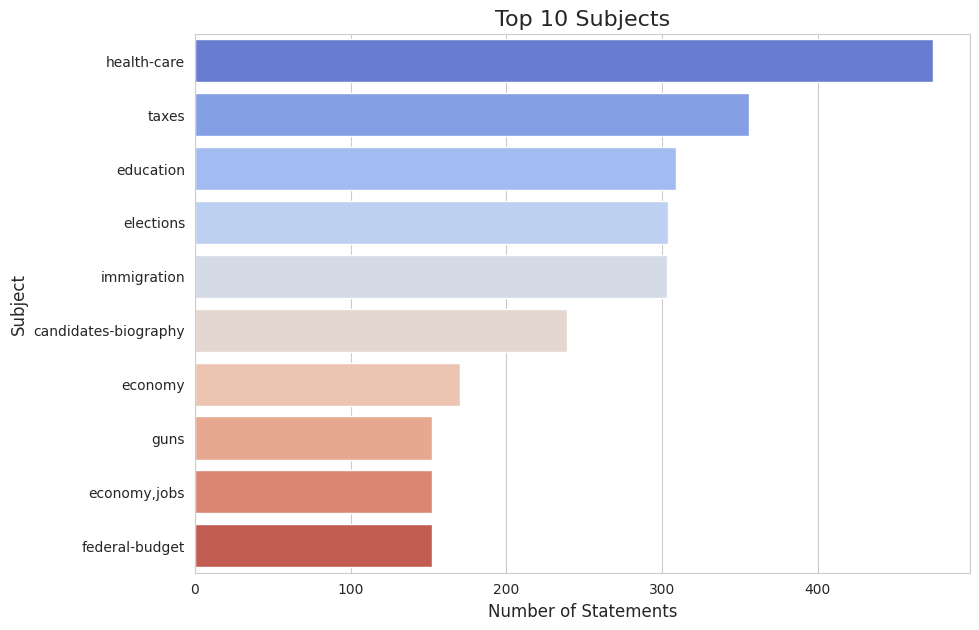

In [9]:
custom_palette = sns.color_palette("coolwarm", 10)
def plot_top_categories(df, column, title, n=10):
    """Counts and plots the top N most frequent categories in a column."""
    counts = df[column].value_counts().head(n)

    plt.figure(figsize=(10, 7))
    sns.barplot(x=counts.values, y=counts.index, palette=custom_palette)

    plt.title(title, fontsize=16)
    plt.xlabel('Number of Statements', fontsize=12)
    plt.ylabel(column.replace('_', ' ').title(), fontsize=12)
    plt.show()

# party affiliations
print("--- Top 10 Party Affiliations ---")
print(liar_df['party_affiliation'].value_counts().head(10))
plot_top_categories(liar_df, 'party_affiliation', 'Top 10 Party Affiliations')

# speakers
print("\n--- Top 10 Speakers ---")
print(liar_df['speaker'].value_counts().head(10))
plot_top_categories(liar_df, 'speaker', 'Top 10 Speakers')

# subject
print("\n--- Top 10 Subjects ---")
print(liar_df['subject'].value_counts().head(10))
plot_top_categories(liar_df, 'subject', 'Top 10 Subjects')

Some quick notes about the party affiliation, speaker, and subject variables.


*   The majority of the party affiliation is dominated by the 2 major US parties, Democrats and Republicans, which makes sense. None is the third largest group, which could include non partisan sources or just missing data.
*   The speaker dataset has a heavy focus on famous politicians like Obama/Trump. There is a heavy skew towards republicans (7 of the 9 people shown). The only non-politician name is "chain-email" which are known to be dubious sources of information.
*  Subjects are all common "divisive" topics where misinformation can be common.






# Statement

/tmp/ipython-input-2506945701.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='word_count', data=liar_df, order=label_order, palette='plasma')


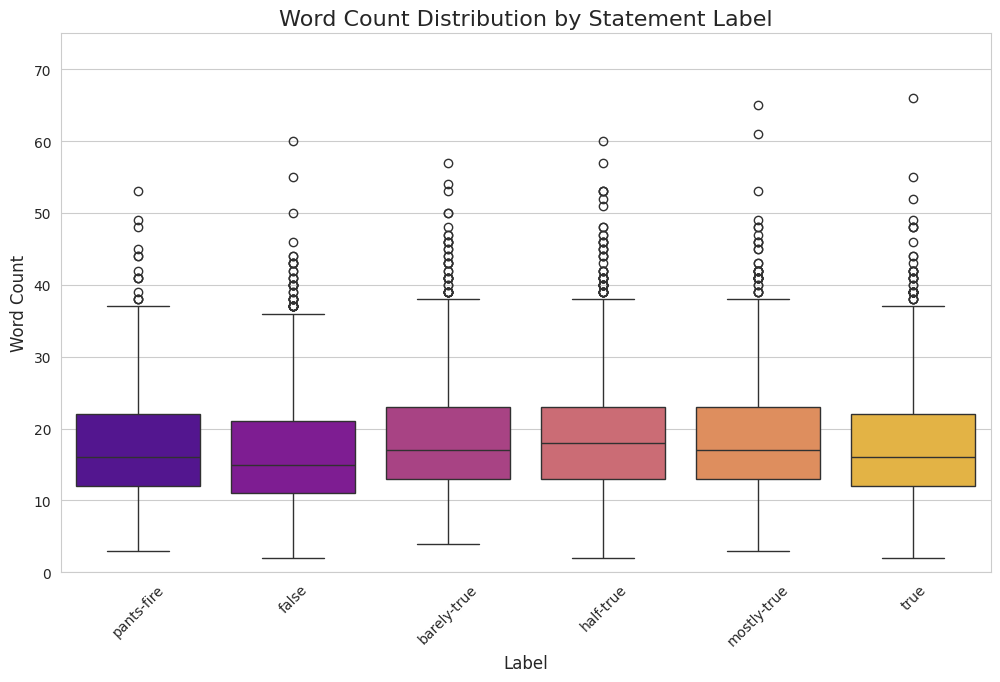

In [10]:
# analyze statement length
liar_df['word_count'] = liar_df['statement'].apply(lambda x: len(str(x).split()))

# box plots separated by label
plt.figure(figsize=(12, 7))
sns.boxplot(x='label', y='word_count', data=liar_df, order=label_order, palette='plasma')

plt.title('Word Count Distribution by Statement Label', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 75) # Limiting y-axis to see the box plots more clearly
plt.show()


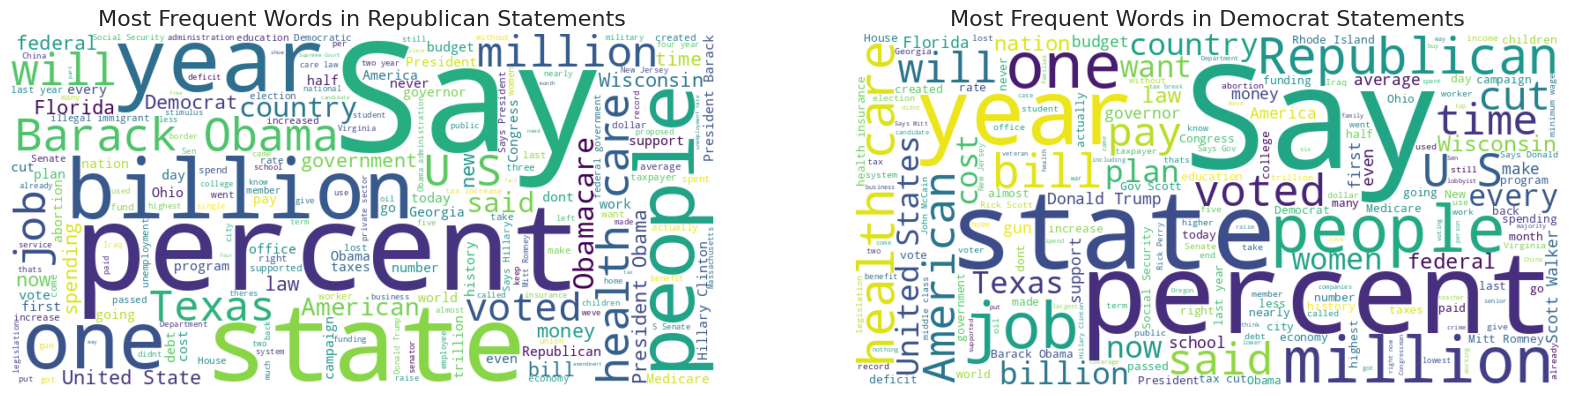

In [11]:
# word clouds!
# calc word counts
liar_df['word_count'] = liar_df['statement'].apply(lambda x: len(str(x).split()))

# separate words by party
republican_text = ' '.join(liar_df[liar_df['party_affiliation'] == 'republican']['statement'].dropna())
democrat_text = ' '.join(liar_df[liar_df['party_affiliation'] == 'democrat']['statement'].dropna())

# create clouds
wc_republican = WordCloud(width=800, height=400, background_color='white').generate(republican_text)
wc_democrat = WordCloud(width=800, height=400, background_color='white').generate(democrat_text)

# plot
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(wc_republican, interpolation='bilinear')
axes[0].set_title('Most Frequent Words in Republican Statements', fontsize=16)
axes[0].axis('off')

axes[1].imshow(wc_democrat, interpolation='bilinear')
axes[1].set_title('Most Frequent Words in Democrat Statements', fontsize=16)
axes[1].axis('off')

plt.show()

# Bivariate Analysis

Now that we have analyzed most of the important variables by themselves, it is now time to see what kinds of relationships they can have with each other.

Because our target variable is label, we will compare some of our other features with label first.

In [25]:
#label vs party affiliation
party_counts = liar_df['party_affiliation'].value_counts()
top5_parties = party_counts.head(5).index
subset = liar_df[liar_df['party_affiliation'].isin(top5_parties)]

# Build cross-tab for just these parties
party_ct = pd.crosstab(subset['party_affiliation'], subset['label'])
party_pct = party_ct.div(party_ct.sum(axis=1), axis=0) * 100

party_pct.round(1).head()


label,barely-true,false,half-true,mostly-true,pants-fire,true
party_affiliation,,,,,,
democrat,14.2,15.3,22.5,24.1,4.5,19.5
independent,15.0,12.8,16.7,37.2,2.2,16.1
none,15.1,19.3,18.0,17.3,16.1,14.2
organization,21.2,22.3,26.5,11.0,8.0,11.0
republican,18.7,22.9,20.0,15.9,8.1,14.3


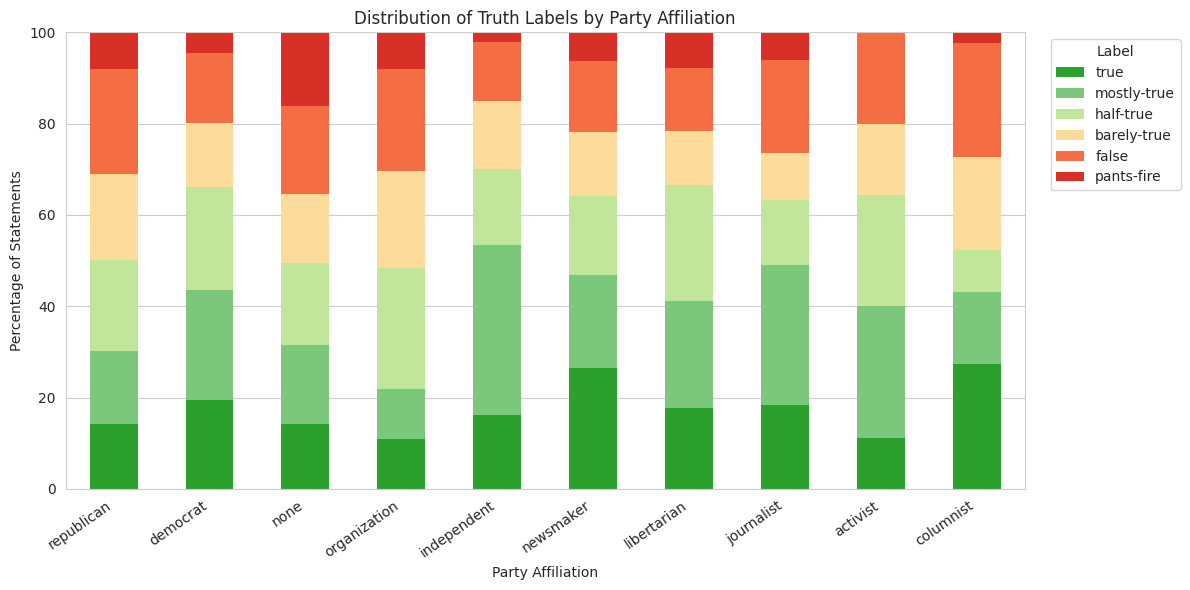

In [27]:
label_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']
party_ct = pd.crosstab(liar_df['party_affiliation'], liar_df['label'])
party_ct = party_ct.reindex(columns=label_order, fill_value=0)

# Order parties by total count, descending (largest left)
party_order = party_ct.sum(axis=1).sort_values(ascending=False).index
party_ct = party_ct.loc[party_order]

# limit to top 10 parties
top_n = 10
party_ct = party_ct.iloc[:top_n]

# Row-normalize to percentages
party_pct = party_ct.div(party_ct.sum(axis=1), axis=0) * 100

# Color gradient (green -> red, with pants-fire red)
color_map = {
    'true':        '#2ca02c',
    'mostly-true': '#7bc87c',
    'half-true':   '#c2e699',
    'barely-true': '#fddc9b',
    'false':       '#f46d43',
    'pants-fire':  '#d73027'
}
colors = [color_map[lbl] for lbl in label_order]

# Plot
ax = party_pct.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors, edgecolor='none')
ax.set_title('Distribution of Truth Labels by Party Affiliation')
ax.set_ylabel('Percentage of Statements')
ax.set_xlabel('Party Affiliation')
ax.set_ylim(0, 100)

plt.xticks(rotation=35, ha='right')

plt.legend(title='Label', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

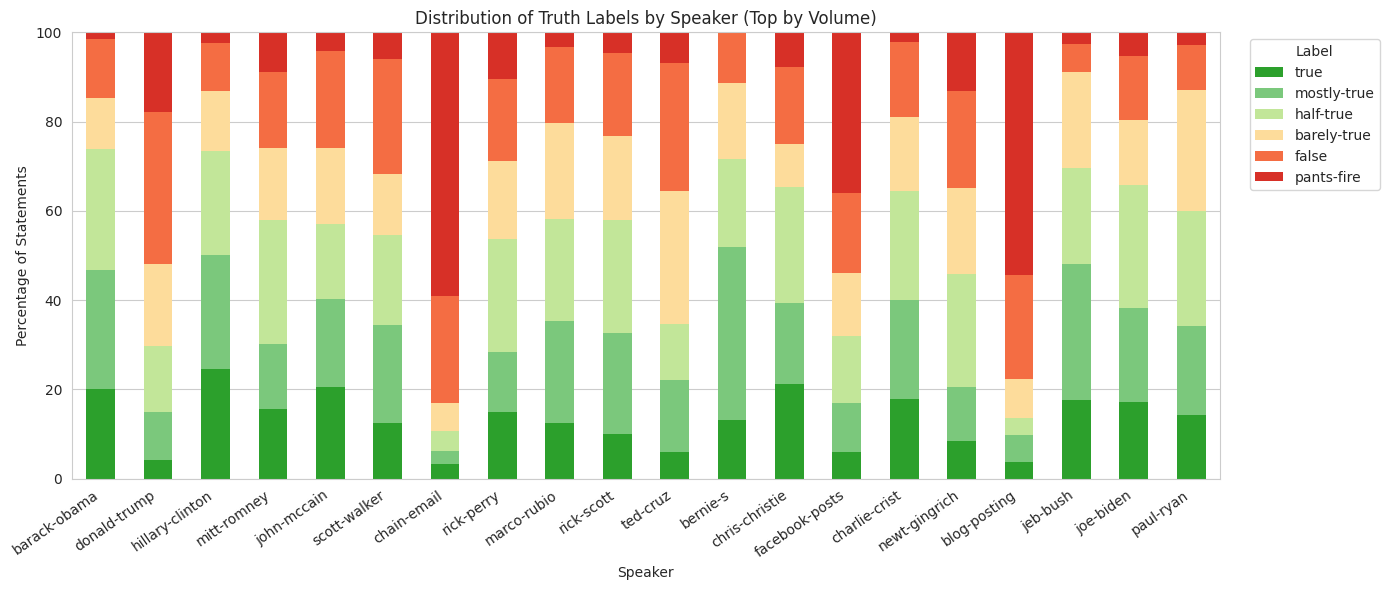

Chi-square: 1160.87, p-value: 7.8765e-183, dof: 95, Cramér’s V: 0.261


In [32]:
# label vs speakers
from scipy.stats import chi2_contingency
label_order = ['true','mostly-true','half-true','barely-true','false','pants-fire']

#pick top 20 speakers
top_n = 20
speaker_counts = liar_df['speaker'].value_counts()
candidates = speaker_counts.index[:top_n]

subset = liar_df[liar_df['speaker'].isin(candidates)].copy()

# Crosstab + enforce label order + sort speakers by total count
speaker_ct = pd.crosstab(subset['speaker'], subset['label'])
speaker_ct = speaker_ct.reindex(columns=label_order, fill_value=0)
speaker_ct = speaker_ct.loc[speaker_ct.sum(axis=1).sort_values(ascending=False).index]

# Normalize to percentages
speaker_pct = speaker_ct.div(speaker_ct.sum(axis=1), axis=0) * 100

# Colors: green -> red gradient
color_map = {
    'true':        '#2ca02c',
    'mostly-true': '#7bc87c',
    'half-true':   '#c2e699',
    'barely-true': '#fddc9b',
    'false':       '#f46d43',
    'pants-fire':  '#d73027'
}
colors = [color_map[l] for l in label_order]

#Plot
ax = speaker_pct.plot(kind='bar', stacked=True, figsize=(14,6), color=colors, edgecolor='none')
ax.set_title('Distribution of Truth Labels by Speaker (Top by Volume)')
ax.set_ylabel('Percentage of Statements')
ax.set_xlabel('Speaker')
ax.set_ylim(0, 100)
plt.xticks(rotation=35, ha='right')
plt.legend(title='Label', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Statistical test (chi-square) + effect size
chi2, p, dof, expected = chi2_contingency(speaker_ct)
n = speaker_ct.to_numpy().sum()
cramers_v = np.sqrt(chi2 / (n * (min(speaker_ct.shape) - 1)))
print(f"Chi-square: {chi2:.2f}, p-value: {p:.4e}, dof: {dof}, Cramér’s V: {cramers_v:.3f}")


As we can see, the top 3 most blantatly false speakers are not actually individuals but methods of recieving information - chain emails, blog posts, and facebook posts. This is closely followed by Donald Trump, who for more than 50% of datapoints are false. For the rest of politicians, it seems that there is an average of about 60% of the article being half true or truer.

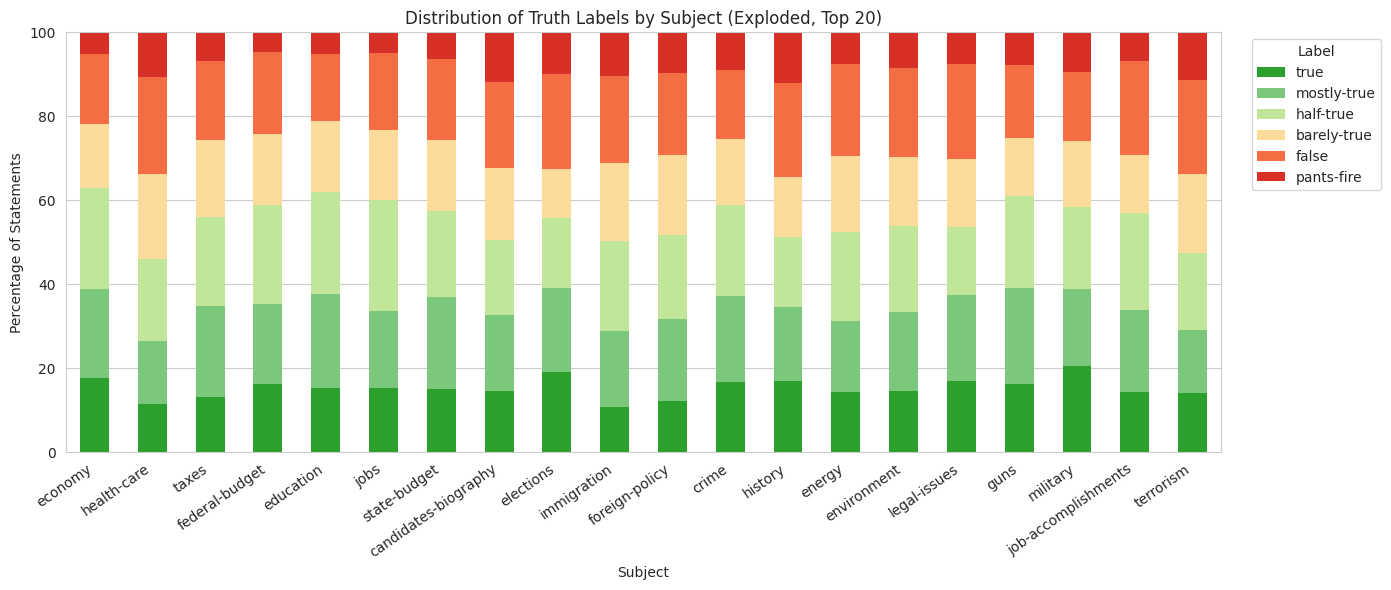

Chi-square: 328.41, p-value: 1.8614e-27, dof: 95, Cramér’s V: 0.067


In [40]:
#label vs subject
import re

label_order = ['true','mostly-true','half-true','barely-true','false','pants-fire']
top_n = 20  # show top 20 subjects

# parse subjects
def split_subjects(x):
    if pd.isna(x):
        return []
    # split on comma, semicolon, pipe, or slash; strip & lowercase
    parts = re.split(r'[,\|;/]+', str(x))
    return [p.strip().lower() for p in parts if p.strip()]

subj_df = liar_df[['label', 'subject']].copy()
subj_df['subjects_list'] = subj_df['subject'].apply(split_subjects)

# explode into one row per (claim, subject)
exploded = subj_df.explode('subjects_list', ignore_index=True)
exploded = exploded[exploded['subjects_list'].notna() & (exploded['subjects_list'] != '')]

# take top 20
subj_counts = exploded['subjects_list'].value_counts()
keep_subjects = subj_counts.index[:top_n]
subset = exploded[exploded['subjects_list'].isin(keep_subjects)].copy()

subj_ct = pd.crosstab(subset['subjects_list'], subset['label'])
subj_ct = subj_ct.reindex(columns=label_order, fill_value=0)
subj_ct = subj_ct.loc[subj_ct.sum(axis=1).sort_values(ascending=False).index]

# % within each subject
subj_pct = subj_ct.div(subj_ct.sum(axis=1), axis=0) * 100

# plot
color_map = {
    'true':        '#2ca02c',
    'mostly-true': '#7bc87c',
    'half-true':   '#c2e699',
    'barely-true': '#fddc9b',
    'false':       '#f46d43',
    'pants-fire':  '#d73027'
}
colors = [color_map[l] for l in label_order]

ax = subj_pct.plot(kind='bar', stacked=True, figsize=(14,6), color=colors, edgecolor='none')
ax.set_title('Distribution of Truth Labels by Subject (Exploded, Top 20)')
ax.set_ylabel('Percentage of Statements')
ax.set_xlabel('Subject')
ax.set_ylim(0, 100)
plt.xticks(rotation=35, ha='right')
plt.legend(title='Label', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# stats
chi2, p, dof, expected = chi2_contingency(subj_ct)
n = subj_ct.to_numpy().sum()
cramers_v = np.sqrt(chi2 / (n * (min(subj_ct.shape) - 1)))
print(f"Chi-square: {chi2:.2f}, p-value: {p:.4e}, dof: {dof}, Cramér’s V: {cramers_v:.3f}")

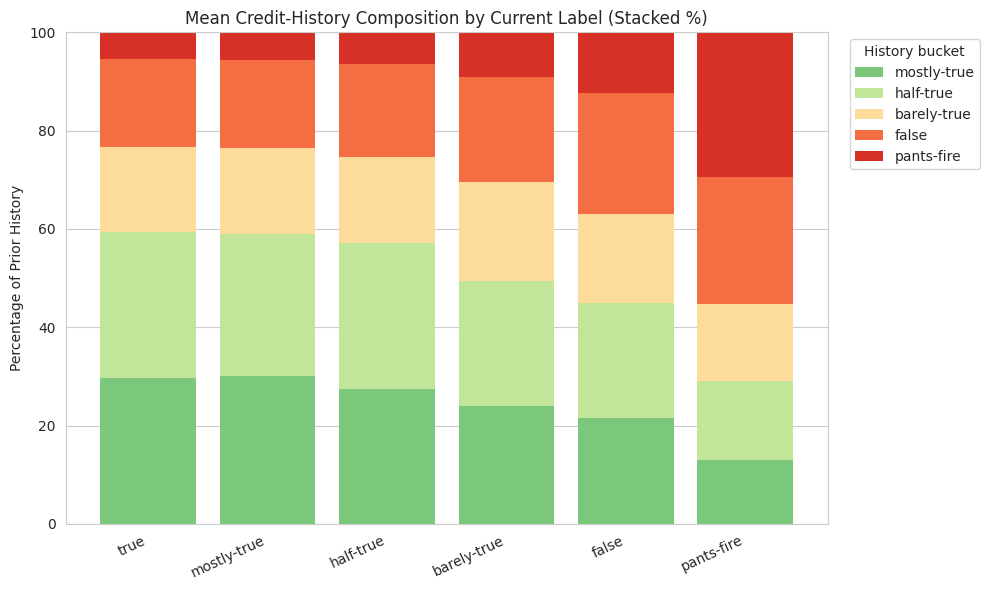

In [43]:
#label vs historical truthfulness
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
label_order = ['true','mostly-true','half-true','barely-true','false','pants-fire']
hist_cols = ['mostly_true_counts', 'half_true_counts', 'barely_true_counts', 'false_counts', 'pants_on_fire_counts']

# Keep relevant columns
work = liar_df[['label'] + hist_cols].copy()

# Convert to numeric and handle missing
for c in hist_cols:
    work[c] = pd.to_numeric(work[c], errors='coerce').fillna(0)

# Drop rows with no prior history
work['hist_total'] = work[hist_cols].sum(axis=1)
work = work[work['hist_total'] > 0].copy()

# Mean composition per current label, normalized to %
comp = work.groupby('label')[hist_cols].mean().reindex(label_order)
comp_pct = comp.div(comp.sum(axis=1), axis=0) * 100

# Pretty display names (for legend)
pretty = {
    'barely_true_counts': 'barely-true',
    'false_counts': 'false',
    'half_true_counts': 'half-true',
    'mostly_true_counts': 'mostly-true',
    'pants_on_fire_counts': 'pants-fire'
}

# Color gradient: green → red
color_map = {
    'mostly-true': '#7bc87c',
    'half-true':   '#c2e699',
    'barely-true': '#fddc9b',
    'false':       '#f46d43',
    'pants-fire':  '#d73027'
}
bar_colors = [color_map[pretty[c]] for c in hist_cols]

# plot
fig, ax = plt.subplots(figsize=(10,6))
bottom = np.zeros(len(comp_pct))
x = np.arange(len(comp_pct.index))

for color, col in zip(bar_colors, hist_cols):
    vals = comp_pct[col].values
    ax.bar(x, vals, bottom=bottom, color=color, edgecolor='none', label=pretty[col])
    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(comp_pct.index, rotation=25, ha='right')
ax.set_ylim(0, 100)
ax.set_ylabel('Percentage of Prior History')
ax.set_title('Mean Credit-History Composition by Current Label (Stacked %)')
ax.legend(title='History bucket', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()
